# Pick and Place in PyBullet

This tutorial shows how to attach a two fingered jaw gripper to the Kuka robot
to pick-and-place objects.

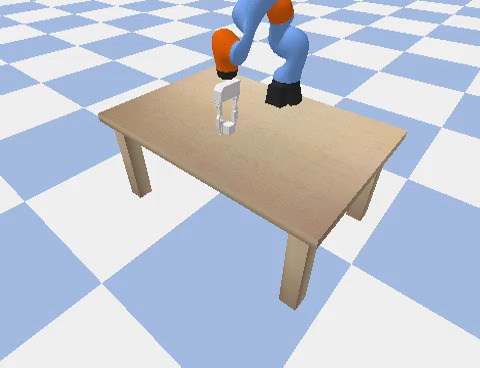

## Initializations

In [1]:

import os
import time
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pybullet as p
import pybullet_data
import cv2
import imageio_ffmpeg
from base64 import b64encode
from IPython.display import HTML

pybullet build time: Jun 17 2025 23:39:29


In [125]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
folderpath = "drive/MyDrive/HackathonProject/"
objectspath = "objects/"

In [127]:
import xml.etree.ElementTree as ET

def print_hammer_dimensions(urdf_path):
    tree = ET.parse(urdf_path)
    root = tree.getroot()

    print(f"Reading dimensions from: {urdf_path}")
    for link in root.findall('link'):
        link_name = link.get('name')
        visual = link.find('visual')
        if visual is None:
            continue

        geometry = visual.find('geometry')
        if geometry is None:
            continue

        print(f"\n🔧 Link: {link_name}")

        # Handle Cylinder
        cylinder = geometry.find('cylinder')
        if cylinder is not None:
            radius = cylinder.attrib.get('radius', 'N/A')
            length = cylinder.attrib.get('length', 'N/A')
            print(f"  - Shape: Cylinder")
            print(f"  - Radius: {radius}")
            print(f"  - Length: {length}")

        # Head Box
        box = geometry.find('box')
        if box is not None:
            size = box.attrib.get('size', 'N/A')
            print(f"  - Shape: Box")
            print(f"  - Size (L W H): {size}")

        # Add other shapes if needed (e.g., sphere, mesh)

print_hammer_dimensions(objectspath + "hammer.urdf")

Reading dimensions from: drive/MyDrive/HackathonProject/Objects/hammer.urdf

🔧 Link: handle
  - Shape: Cylinder
  - Radius: 0.3
  - Length: 6.0

🔧 Link: head
  - Shape: Box
  - Size (L W H): 2.0 0.6 0.6


## Time-based simulations

timestep 749...

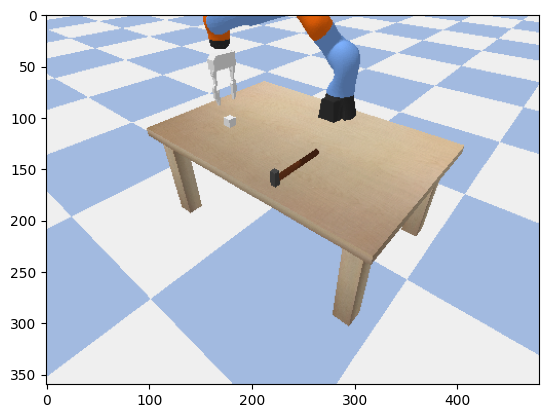

In [ ]:
import math

p.connect(p.DIRECT) #p.DIRECT or p.GUI for graphical version
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.setGravity(0,0,-10)

plane_id = p.loadURDF("plane.urdf")
kuka_id = p.loadURDF("kuka_iiwa/model_vr_limits.urdf", 1.400000, -0.200000, 0.600000, 0.000000, 0.000000, 0.000000, 1.000000)
kuka_gripper_id = p.loadSDF("gripper/wsg50_one_motor_gripper_new_free_base.sdf")[0]

table_id = p.loadURDF("table/table.urdf", basePosition=[1.0, -0.2, 0.0], baseOrientation=[0, 0, 0.7071, 0.7071])
cube_id = p.loadURDF("cube.urdf", basePosition=[0.85, -0.2, 0.65], globalScaling=0.05)
# cube_id2 = p.loadURDF("cube.urdf", basePosition=[0.7, -0.2, 0.65], globalScaling=0.05)
# tool_id = p.loadURDF(folderpath + "hammer.urdf", basePosition=[0.7, -0.2, 0.65], globalScaling=0.05)
# Load hammer lying flat on the table
hammer_position = [0.9, -0.4, 0.65]  # Adjusted for proper table height
hammer_orientation = p.getQuaternionFromEuler([0, -math.pi/2, 0])  # Lay flat
hammer_id = p.loadURDF(folderpath + "hammer.urdf",
                     basePosition=hammer_position,
                     baseOrientation=hammer_orientation,
                     globalScaling=0.05)

# Set hammer to be static initially
p.changeDynamics(hammer_id, -1,
                 mass=0,  # Make base link static
                 linearDamping=100.0,
                 angularDamping=100.0,
                 lateralFriction=10.0,
                 spinningFriction=10.0,
                 rollingFriction=10.0)

# Apply high damping to all links
for i in range(p.getNumJoints(hammer_id)):
    p.changeDynamics(hammer_id, i,
                     linearDamping=100.0,
                     angularDamping=100.0,
                     lateralFriction=10.0,
                     spinningFriction=10.0,
                     rollingFriction=10.0)

# Let simulation settle
for _ in range(100):
    p.stepSimulation()

# attach gripper to kuka arm
kuka_cid = p.createConstraint(kuka_id, 6, kuka_gripper_id, 0, p.JOINT_FIXED, [0, 0, 0], [0, 0, 0.05], [0, 0, 0])
kuka_cid2 = p.createConstraint(kuka_gripper_id, 4, kuka_gripper_id, 6, jointType=p.JOINT_GEAR, jointAxis=[1,1,1], parentFramePosition=[0,0,0], childFramePosition=[0,0,0])
p.changeConstraint(kuka_cid2, gearRatio=-1, erp=0.5, relativePositionTarget=0, maxForce=100)

# reset kuka
jointPositions = [-0.000000, -0.000000, 0.000000, 1.570793, 0.000000, -1.036725, 0.000001]
for jointIndex in range(p.getNumJoints(kuka_id)):
    p.resetJointState(kuka_id, jointIndex, jointPositions[jointIndex])
    p.setJointMotorControl2(kuka_id, jointIndex, p.POSITION_CONTROL, jointPositions[jointIndex], 0)

# reset gripper
p.resetBasePositionAndOrientation(kuka_gripper_id, [0.923103, -0.200000, 1.250036], [-0.000000, 0.964531, -0.000002, -0.263970])
jointPositions = [0.000000, -0.011130, -0.206421, 0.205143, -0.009999, 0.000000, -0.010055, 0.000000]
for jointIndex in range(p.getNumJoints(kuka_gripper_id)):
    p.resetJointState(kuka_gripper_id, jointIndex, jointPositions[jointIndex])
    p.setJointMotorControl2(kuka_gripper_id, jointIndex, p.POSITION_CONTROL, jointPositions[jointIndex], 0)

num_joints = p.getNumJoints(kuka_id)
kuka_end_effector_idx = 6

# camera parameters
cam_target_pos = [.95, -0.2, 0.2]
cam_distance = 2.05
cam_yaw, cam_pitch, cam_roll = -50, -40, 0
cam_width, cam_height = 480, 360

cam_up, cam_up_axis_idx, cam_near_plane, cam_far_plane, cam_fov = [0, 0, 1], 2, 0.01, 100, 60

#video = cv2.VideoWriter('vid.avi', cv2.VideoWriter_fourcc(*'XVID'), 30, (cam_width, cam_height)) # Does not seem to support h264!
vid = imageio_ffmpeg.write_frames('vid.mp4', (cam_width, cam_height), fps=30)
vid.send(None) # seed the video writer with a blank frame

for t in range(750):
    print(f'\rtimestep {t}...', end='')

    if t % 8 == 0: # PyBullet default simulation time step is 240fps, but we want to record video at 30fps.
        cam_view_matrix = p.computeViewMatrixFromYawPitchRoll(cam_target_pos, cam_distance, cam_yaw, cam_pitch, cam_roll, cam_up_axis_idx)
        cam_projection_matrix = p.computeProjectionMatrixFOV(cam_fov, cam_width*1./cam_height, cam_near_plane, cam_far_plane)
        image = p.getCameraImage(cam_width, cam_height, cam_view_matrix, cam_projection_matrix)[2][:, :, :3]
        #video.write(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        vid.send(np.ascontiguousarray(image))

    target_pos, gripper_val = [0.85, -0.2, 0.97], 0
    if t >= 150 and t < 250:
        target_pos, gripper_val = [0.85, -0.2, 0.97], 1 # grab object
    elif t >= 250 and t < 400:
        target_pos, gripper_val = [0.85, -0.2, 0.97 + 0.13*(t-250)/150.], 1 # move up after picking object
    elif t >= 400 and t < 600:
        target_pos, gripper_val = [0.85, -0.2 + 0.4*(t-400)/200., 1.1], 1 # move to target position
    elif t >= 600 and t < 700:
        target_pos, gripper_val = [0.85, 0.2, 1.1], 1 # stop at target position
    elif t >= 700:
        target_pos, gripper_val = [0.85, 0.2, 1.1], 0 # drop object

    target_orn = p.getQuaternionFromEuler([0, 1.01*math.pi, 0])
    joint_poses = p.calculateInverseKinematics(kuka_id, kuka_end_effector_idx, target_pos, target_orn)
    for j in range (num_joints):
        p.setJointMotorControl2(bodyIndex=kuka_id, jointIndex=j, controlMode=p.POSITION_CONTROL, targetPosition=joint_poses[j])

    p.setJointMotorControl2(kuka_gripper_id, 4, p.POSITION_CONTROL, targetPosition=gripper_val*0.05, force=100)
    p.setJointMotorControl2(kuka_gripper_id, 6, p.POSITION_CONTROL, targetPosition=gripper_val*0.05, force=100)

    p.stepSimulation()

plt.imshow(Image.fromarray(image)) # show the last frame

vid.close()
#video.release()
p.disconnect()

In [ ]:
# Play recorded video

#os.system(f"ffmpeg -y -i vid.avi -vcodec libx264 vidc.mp4") # convert to mp4 to show in browser
mp4 = open('vid.mp4', 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=480 controls><source src="%s" type="video/mp4"></video>' % data_url)

## API Implementation

In [3]:
gripper_length = 0.25

def capture_frame(t):
    if t % 8 == 0:
        view_matrix = p.computeViewMatrixFromYawPitchRoll(
            cam_target_pos, cam_distance, cam_yaw, cam_pitch, cam_roll, cam_up_axis_idx
        )
        proj_matrix = p.computeProjectionMatrixFOV(
            cam_fov, cam_width / cam_height, cam_near_plane, cam_far_plane
        )

        # Use TINY_RENDERER for reliability in p.DIRECT or headless mode
        width, height, rgb_pixels, *_ = p.getCameraImage(
            cam_width, cam_height, view_matrix, proj_matrix,
            renderer=p.ER_TINY_RENDERER
        )

        # Reshape to (H, W, 4), force dtype, slice RGB
        image = np.array(rgb_pixels, dtype=np.uint8).reshape(
            (height, width, 4))[:, :, :3]

        # Write frame to video
        vid.send(np.ascontiguousarray(image))


def set_arm(target_pos, steps=150, target_orn=None):
    if target_orn is None:
        target_orn = p.getQuaternionFromEuler([0, math.pi, 0])
    elif isinstance(target_orn, list) and len(target_orn) == 3:
        target_orn = p.getQuaternionFromEuler(target_orn)

    target_joint_poses = p.calculateInverseKinematics(
        kuka_id, kuka_end_effector_idx, target_pos, target_orn)

    # Get current joint positions
    current_joint_poses = [p.getJointState(
        kuka_id, j)[0] for j in range(num_joints)]

    for t in range(steps):
        frac = t / steps
        interp_poses = [
            (1 - frac) * current + frac * target
            for current, target in zip(current_joint_poses, target_joint_poses)
        ]

        for j in range(num_joints):
            p.setJointMotorControl2(
                bodyIndex=kuka_id,
                jointIndex=j,
                controlMode=p.POSITION_CONTROL,
                targetPosition=interp_poses[j]
            )

        if t % 8 == 0:
            capture_frame(t)
        p.stepSimulation()


def set_gripper(closed, duration=1.2):
    steps = int(duration * 240)
    target_pos = 0.05 if closed else 0.0
    current_pos = p.getJointState(kuka_gripper_id, 4)[
        0]  # assume symmetrical gripper

    for t in range(steps):
        frac = t / steps
        interp_pos = (1 - frac) * current_pos + frac * target_pos

        p.setJointMotorControl2(
            kuka_gripper_id, 4, p.POSITION_CONTROL, targetPosition=interp_pos, force=100)
        p.setJointMotorControl2(
            kuka_gripper_id, 6, p.POSITION_CONTROL, targetPosition=interp_pos, force=100)

        if t % 8 == 0:
            capture_frame(t)
        p.stepSimulation()


# Expose functions
def move_arm(target, target_orn=None):
    target[2] += gripper_length
    set_arm(target_pos=target, target_orn=target_orn)

def open_gripper():
    set_gripper(closed=False)

def close_gripper():
    set_gripper(closed=True)

## Loading the sim environment

In [372]:
p.disconnect()

In [4]:
p.connect(p.DIRECT)  # or p.GUI for graphical version
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.setGravity(0, 0, -10)

plane_id = p.loadURDF("plane.urdf")
kuka_id = p.loadURDF("kuka_iiwa/model_vr_limits.urdf", 1.400000, -
                     0.200000, 0.600000, 0.000000, 0.000000, 0.000000, 1.000000)
kuka_gripper_id = p.loadSDF(
    "gripper/wsg50_one_motor_gripper_new_free_base.sdf")[0]
# Friction on the gripper fingers (assuming gripper has multiple links)
for i in range(p.getNumJoints(kuka_gripper_id)):
    p.changeDynamics(kuka_gripper_id, i,
                    lateralFriction=0.9,   # Moderate friction
                    spinningFriction=0.07)
table_id = p.loadURDF("table/table.urdf", basePosition=[1.0, -0.2, 0.0], baseOrientation=[0, 0, 0.7071, 0.7071])
# Set friction for the table
p.changeDynamics(table_id, -1, lateralFriction=0.8, spinningFriction=0.1, rollingFriction=0.01)

# plate_pos = [0.7, -0.3, 0.65]
# plate_id = p.loadURDF(objectspath + "plate.urdf", basePosition=plate_pos, globalScaling=0.05)

apple_pos = [0.8, -0.3, 0.6849899910813102]
apple_id = p.loadURDF(objectspath + "apple.urdf", basePosition=apple_pos, globalScaling=0.04)
# Friction on the apple
p.changeDynamics(apple_id, -1,
                lateralFriction=1.2,
                spinningFriction=0.08,
                rollingFriction=0.2)

bottle_pos = [0.7, 0.1, 0.8]
bottle_id = p.loadURDF(objectspath + "bottle.urdf", basePosition=bottle_pos, globalScaling=0.05)
# Add a little friction to the bottle
p.changeDynamics(bottle_id, -1,  # -1 applies to all links
                lateralFriction=0.5,      # Small amount of friction
                spinningFriction=0.02,    # Very light spinning friction
                rollingFriction=0.01)     # Very light rolling friction

box_pos = [1, 0.1, 0.7]
box_id = p.loadURDF(objectspath + "box.urdf", basePosition=box_pos, globalScaling=0.05)

banana_pos = [0.893, 0.313, 0.660]
banana_orn = [0.997, 0.000, 0.030, -0.073]
banana_id = p.loadURDF(objectspath + "banana.urdf", basePosition=banana_pos, baseOrientation=banana_orn, globalScaling=0.035)

container_pos = [0.9, -0.75, 0.73]
container_id = p.loadURDF(objectspath + "container.urdf", basePosition=container_pos, globalScaling=0.05)

hammer_pos = [1, -0.2, 0.7]
hammer_orn = p.getQuaternionFromEuler([math.pi/2, -math.pi/2, math.pi])  # Lay flat
hammer_id = p.loadURDF(objectspath + "hammer.urdf",
                     basePosition=hammer_pos,
                     baseOrientation=hammer_orn,
                     globalScaling=0.05)

# attach gripper to kuka arm
kuka_cid = p.createConstraint(kuka_id, 6, kuka_gripper_id, 0, p.JOINT_FIXED, [
                              0, 0, 0], [0, 0, 0.05], [0, 0, 0])
kuka_cid2 = p.createConstraint(kuka_gripper_id, 4, kuka_gripper_id, 6, jointType=p.JOINT_GEAR, jointAxis=[
                               1, 1, 1], parentFramePosition=[0, 0, 0], childFramePosition=[0, 0, 0])
p.changeConstraint(kuka_cid2, gearRatio=-1, erp=0.5,
                   relativePositionTarget=0, maxForce=100)

# reset kuka
jointPositions = [-0.000000, -0.000000, 0.000000,
                  1.570793, 0.000000, -1.036725, 0.000001]
for jointIndex in range(p.getNumJoints(kuka_id)):
    p.resetJointState(kuka_id, jointIndex, jointPositions[jointIndex])
    p.setJointMotorControl2(kuka_id, jointIndex,
                            p.POSITION_CONTROL, jointPositions[jointIndex], 0)

# reset gripper
p.resetBasePositionAndOrientation(kuka_gripper_id, [
                                  0.923103, -0.200000, 1.250036], [-0.000000, 0.964531, -0.000002, -0.263970])
jointPositions = [0.000000, -0.011130, -0.206421,
                  0.205143, -0.009999, 0.000000, -0.010055, 0.000000]
for jointIndex in range(p.getNumJoints(kuka_gripper_id)):
    p.resetJointState(kuka_gripper_id, jointIndex, jointPositions[jointIndex])
    p.setJointMotorControl2(kuka_gripper_id, jointIndex,
                            p.POSITION_CONTROL, jointPositions[jointIndex], 0)

num_joints = p.getNumJoints(kuka_id)
kuka_end_effector_idx = 6

# camera parameters
cam_target_pos = [.95, -0.2, 0.2]
cam_distance = 2.05
cam_yaw, cam_pitch, cam_roll = -60, -40, 0
cam_width, cam_height = 480, 360

cam_up, cam_up_axis_idx, cam_near_plane, cam_far_plane, cam_fov = [
    0, 0, 1], 2, 0.01, 100, 60

# video = cv2.VideoWriter('vid.avi', cv2.VideoWriter_fourcc(*'XVID'), 30, (cam_width, cam_height)) # Does not seem to support h264!
vid = imageio_ffmpeg.write_frames('vid.mp4', (cam_width, cam_height), fps=30)
vid.send(None)  # seed the video writer with a blank frame

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (480, 360) to (480, 368) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


## Testing some stuff

In [204]:
# Get the end effector (link 6) position
end_effector_state = p.getLinkState(kuka_id, kuka_end_effector_idx)
end_effector_pos = end_effector_state[0]  # World position of link 6
end_effector_orn = end_effector_state[1]  # World orientation of link 6

print(f"End effector (link {kuka_end_effector_idx}) position: {end_effector_pos}")

# Get the gripper base position
gripper_base_pos, gripper_base_orn = p.getBasePositionAndOrientation(kuka_gripper_id)
print(f"Gripper base position: {gripper_base_pos}")

# Find the gripper tip - usually the furthest point along the gripper
# First, let's examine all links in the gripper
num_gripper_joints = p.getNumJoints(kuka_gripper_id)
print(f"\nGripper has {num_gripper_joints} joints/links")

# Get positions of all gripper links to find the tip
gripper_link_positions = []
for i in range(-1, num_gripper_joints):  # -1 is base link
    if i == -1:
        pos, _ = p.getBasePositionAndOrientation(kuka_gripper_id)
        name = "base"
    else:
        link_state = p.getLinkState(kuka_gripper_id, i)
        pos = link_state[0]
        joint_info = p.getJointInfo(kuka_gripper_id, i)
        name = joint_info[12].decode('utf-8')  # Link name

    gripper_link_positions.append((name, pos))
    print(f"Link {i} ({name}): {pos}")

# Find the furthest point from the arm (likely the gripper tip)
max_dist = 0
tip_pos = None
tip_name = None

for name, pos in gripper_link_positions:
    dist = ((pos[0] - end_effector_pos[0])**2 +
            (pos[1] - end_effector_pos[1])**2 +
            (pos[2] - end_effector_pos[2])**2)**0.5
    if dist > max_dist:
        max_dist = dist
        tip_pos = pos
        tip_name = name

print(f"\nGripper tip (furthest from end effector): {tip_name}")
print(f"Gripper tip position: {tip_pos}")
print(f"Distance from end effector to gripper tip: {max_dist:.4f}")

# Calculate offset vector
if tip_pos:
    offset = [tip_pos[0] - end_effector_pos[0],
              tip_pos[1] - end_effector_pos[1],
              tip_pos[2] - end_effector_pos[2]]
    print(f"Offset vector from end effector to tip: {offset}")

    # Transform to local coordinates of the end effector
    import numpy as np
    # Convert quaternion to rotation matrix
    rot_matrix = p.getMatrixFromQuaternion(end_effector_orn)
    rot_matrix = np.array(rot_matrix).reshape(3, 3)

    # Transform offset to local coordinates
    local_offset = rot_matrix.T @ np.array(offset)
    print(f"Offset in end effector local frame: {local_offset}")

error: Not connected to physics server.

In [198]:
aabb_min, aabb_max = p.getAABB(table_id)
table_height = aabb_max[2]  # Maximum z-coordinate
print(f"Table height: {table_height}")

Table height: 0.626


## Simulation videos

In [376]:
# @title Just one object
obj_pos = apple_pos
obj_id = apple_id
orn = [0, math.pi, math.pi/2]
dist_above = 0.25

above_obj = obj_pos.copy()
above_obj[2] += dist_above
move_arm(above_obj, orn)

# # Retrieve current object position and orientation
# current_pos, current_orn = p.getBasePositionAndOrientation(obj_id)

# # Convert quaternion to Euler angles if needed
# current_euler = p.getEulerFromQuaternion(current_orn)

# print(f"Current object position: {current_pos}")
# print(f"Current object orientation (quaternion): {current_orn}")
# print(f"Current object orientation (Euler): {current_euler}")

move_arm(obj_pos, orn) # move to object
close_gripper()
move_arm(above_obj)

above_container = container_pos.copy()
above_container[2] += 0.2
move_arm(above_container) # container
open_gripper()
move_arm([0.85, -0.2, 0.9], target_orn=[0, math.pi, math.pi/2])

# # Get obj position and orientation
# obj_id = apple_id

# # Convert quaternion to Euler angles for easier interpretation
# banana_euler = p.getEulerFromQuaternion(banana_orn)

# print(f"\nBanana final state:")
# print(f"Position: x={obj_pos[0]:.3f}, y={obj_pos[1]:.3f}, z={obj_pos[2]:.3f}")
# print(f"Orientation (quaternion): {[f'{q:.3f}' for q in banana_orn]}")
# print(f"Orientation (Euler): roll={banana_euler[0]:.3f}, pitch={banana_euler[1]:.3f}, yaw={banana_euler[2]:.3f} rad")
# print(f"Orientation (Euler degrees): roll={math.degrees(banana_euler[0]):.1f}°, pitch={math.degrees(banana_euler[1]):.1f}°, yaw={math.degrees(banana_euler[2]):.1f}°")

# # Also get the bounding box to see the apple's extent
# aabb_min, aabb_max = p.getAABB(obj_id)
# print(f"\nBanana bounding box:")
# print(f"Min: {[f'{v:.3f}' for v in aabb_min]}")
# print(f"Max: {[f'{v:.3f}' for v in aabb_max]}")
# print(f"Height: {aabb_min[2]:.3f}")

vid.close()
p.disconnect()

# Play recorded video
# os.system(f"ffmpeg -y -i vid.avi -vcodec libx264 vidc.mp4") # convert to mp4 to show in browser
mp4 = open('vid.mp4', 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=480 controls><source src="%s" type="video/mp4"></video>' % data_url)

In [ ]:
# @title All objects
for obj_pos in [banana_pos, bottle_pos, apple_pos, box_pos]:
  orn = [0, math.pi, math.pi/2]
  dist_above = 0.25

  above_obj = obj_pos.copy()
  above_obj[2] += dist_above
  move_arm(above_obj, orn)
  move_arm(obj_pos, orn) # move to object
  close_gripper()
  move_arm(above_obj)

  above_container = container_pos.copy()
  above_container[2] += 0.2
  move_arm(above_container) # container
  open_gripper()
  move_arm([0.85, -0.2, 0.9], target_orn=[0, math.pi, math.pi/2])

for obj_pos in [hammer_pos]:
  orn = [0, math.pi, 0]
  dist_above = 0.25

  above_obj = obj_pos.copy()
  above_obj[2] += dist_above
  move_arm(above_obj, orn)
  move_arm(obj_pos, orn) # move to object
  close_gripper()
  move_arm(above_obj)

  above_container = container_pos.copy()
  above_container[2] += 0.2
  move_arm(above_container) # container
  open_gripper()
  move_arm([0.85, -0.2, 0.9], target_orn=[0, math.pi, math.pi/2])

vid.close()
p.disconnect()

# Play recorded video
# os.system(f"ffmpeg -y -i vid.avi -vcodec libx264 vidc.mp4") # convert to mp4 to show in browser
mp4 = open('vid.mp4', 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=480 controls><source src="%s" type="video/mp4"></video>' % data_url)

In [209]:
# @title Table touch
move_arm([1, -0.3, 0.834, 0, math.pi, 0])
vid.close()
p.disconnect()

# Play recorded video
# os.system(f"ffmpeg -y -i vid.avi -vcodec libx264 vidc.mp4") # convert to mp4 to show in browser
mp4 = open('vid.mp4', 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=480 controls><source src="%s" type="video/mp4"></video>' % data_url)